# Looker E-Commerce - Descriptive & Prescriptive Analysis

![estore](UX-Design-Trends-for-E-commerce-Websites-in-2024.jpg)

# Inventory Intelligence: Performance, Prioritization, and Fulfillment Optimization

For this data science–driven inventory analysis, we conducted four distinct evaluations focused on SKU-level performance and supply chain efficiency:

**SKU Velocity Classification**  
Rule-based classification of SKUs into Fast, Slow, and Obsolete categories using creation and sale timestamps.  
*Outcome*: Identification of high-priority SKUs for restocking and low-performing items for potential phase-out.

**ABC Revenue Classification**  
Cumulative revenue analysis to segment products into A, B, and C classes based on contribution to total sales.  
*Outcome*: Strategic procurement guidance to focus on top earners and reduce excess inventory.

**Delivery Timeliness Assessment**  
Time-based analysis of shipment and delivery timestamps across product categories.  
*Outcome*: Identification of fast and slow-moving categories to inform vendor SLAs and inventory planning.

**Order Fulfillment Efficiency**  
Measurement of internal processing speed from order placement to shipment.  
*Outcome*: Benchmarking of enterprise-wide fulfillment lag to support workflow optimization and lead time management.

We ensured alignment with enterprise objectives by consolidating analyses across ~490K SKUs and ~62K transactions, delivering a cohesive and strategic overview of inventory performance.

**Dataset**: https://www.kaggle.com/datasets/mustafakeser4/looker-ecommerce-bigquery-dataset?select=order_items.csv

**Composed by**: ilin3ccc.GITHUB


## 📁 Setup & Data Loading

This section loads all relevant datasets used throughout the analysis. By importing inventory, product metadata, orders, and order items, we ensure full visibility across SKU movement, sales, and fulfillment.

In [1]:
import pandas as pd

# Load all datasets
df_inventory = pd.read_csv("inventory_items.csv")
df_products = pd.read_csv("products.csv")
df_orders = pd.read_csv("orders.csv")
df_order_items = pd.read_csv("order_items.csv")

# Quick peek
print("Inventory shape:", df_inventory.shape)
print("Inventory columns:", df_inventory.columns.tolist())
df_inventory.head()

Inventory shape: (490705, 12)
Inventory columns: ['inventory_items_id', 'product_id', 'created_at', 'sold_at', 'cost', 'product_category', 'product_name', 'product_brand', 'product_retail_price', 'product_department', 'product_sku', 'distribution_center_id']


,inventory_items_id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,distribution_center_id
0,67971,13844,2022-07-02 07:09:20+00:00,2022-07-24 06:33:20+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,67972,13844,2023-12-20 03:28:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,67973,13844,2023-06-04 02:53:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,72863,13844,2021-10-16 22:58:52+00:00,2021-11-22 02:19:52+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,72864,13844,2021-08-07 16:33:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


# SKU Velocity Classification

## 🏷️ Section 1: Velocity Feature Engineering

This section creates movement-based features to understand how quickly inventory items are selling. By calculating the time between item creation and sale, and tracking how long items have been sitting unsold, we lay the foundation for classifying SKUs into Fast, Slow, or Obsolete categories.


In [2]:
from datetime import datetime, timezone

# Get current UTC timestamp
today = pd.Timestamp(datetime.now(timezone.utc))

# Convert timestamps using format='mixed' to handle ISO 8601 with microseconds and timezone
df_inventory["created_at"] = pd.to_datetime(df_inventory["created_at"], format="mixed")
df_inventory["sold_at"] = pd.to_datetime(df_inventory["sold_at"], format="mixed")

# Calculate movement time (days between creation and sale)
df_inventory["movement_time"] = (
    df_inventory["sold_at"] - df_inventory["created_at"]
).dt.days

# Days since last sale (if sold)
df_inventory["days_since_sale"] = df_inventory["sold_at"].apply(
    lambda x: (today - x).days if pd.notnull(x) else None
)

# Days since item was added to inventory
df_inventory["days_since_creation"] = (today - df_inventory["created_at"]).dt.days


## 🧠 Section 2: SKU Classification

This section assigns each inventory item a velocity label—**Fast**, **Slow**, or **Obsolete**—based on how quickly it moves through the system. Items sold quickly are labeled Fast, those with moderate movement are Slow, and stagnant or unsold items are marked Obsolete.


In [3]:
def classify_sku(row):
    # If item has been sold
    if pd.notnull(row["sold_at"]):
        if row["movement_time"] <= 30:
            return "Fast"
        elif row["movement_time"] <= 90:
            return "Slow"
        else:
            return "Obsolete"
    else:
        # Unsold items: classify based on how long they've been sitting
        if row["days_since_creation"] > 180:
            return "Obsolete"
        elif row["days_since_creation"] > 90:
            return "Slow"
        else:
            return "Fast"

df_inventory["velocity_label"] = df_inventory.apply(classify_sku, axis=1)


## 📊 Section 3: Velocity Label Distribution

This chart shows how your inventory is classified, helping you spot trends in product movement and identify potential bottlenecks or overstocked items.


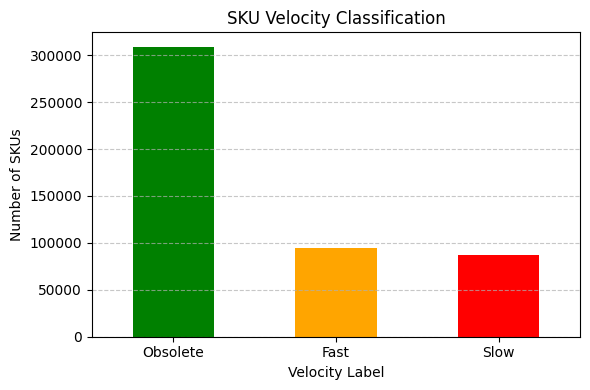

In [4]:
import matplotlib.pyplot as plt

# Count labels
label_counts = df_inventory["velocity_label"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
label_counts.plot(kind="bar", color=["green", "orange", "red"])
plt.title("SKU Velocity Classification")
plt.xlabel("Velocity Label")
plt.ylabel("Number of SKUs")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## 🧮 Section 4: Inventory Optimization Strategy

This section translates velocity labels into strategic inventory actions. By mapping each SKU to a recommended treatment—restock, monitor, or phase out—we support smarter procurement and warehouse decisions.

Restock Priority → Fast movers that need replenishment

Monitor → Slow movers that may be seasonal or niche

Phase Out → Obsolete SKUs that tie up space and capital


In [5]:
def inventory_action(label):
    if label == "Fast":
        return "Restock Priority"
    elif label == "Slow":
        return "Monitor"
    elif label == "Obsolete":
        return "Phase Out"
    else:
        return "Review"

df_inventory["inventory_action"] = df_inventory["velocity_label"].apply(inventory_action)

# Preview action distribution
action_counts = df_inventory["inventory_action"].value_counts()
print("📦 Inventory Action Summary:")
print(action_counts)


📦 Inventory Action Summary:
inventory_action
Phase Out           308946
Restock Priority     94168
Monitor              87591
Name: count, dtype: int64


# 💰 ABC Revenue Classification Analysis

This analysis segments SKUs based on their contribution to total revenue, helping prioritize inventory decisions. We’ll break it down into clear steps, starting with Section 1.


## 📊 Section 1: Revenue-Based Ranking & Cumulative Contribution

We begin by ranking SKUs by revenue and calculating their cumulative contribution to total revenue. This sets the stage for ABC segmentation.


In [10]:
# ✅ Estimate revenue using retail price × recency score
# Avoid division by zero by adding 1 to days_since_sale
df_inventory["recency_score"] = 1 / (df_inventory["days_since_sale"] + 1)

# Estimate revenue
df_inventory["estimated_revenue"] = df_inventory["product_retail_price"] * df_inventory["recency_score"]

# ✅ Sort SKUs by estimated revenue
df_inventory = df_inventory.sort_values(by="estimated_revenue", ascending=False)

# ✅ Calculate cumulative revenue percentage
df_inventory["cumulative_revenue_pct"] = (
    df_inventory["estimated_revenue"].cumsum() / df_inventory["estimated_revenue"].sum() * 100
)

# ✅ Preview top SKUs
print(df_inventory[["product_sku", "estimated_revenue", "cumulative_revenue_pct"]].head())


                             product_sku  estimated_revenue  \
225986  A697AB0DCF803186970E7BB5ED0909FB           1.709845   
220061  8F2964FEECE20703C6AC571342060991           1.643599   
342574  5D147304859C2C8752CF5DEDB4B50D49           1.567708   
222994  07E99F116B916656B3FD4F7DD58A3CBE           1.564991   
223081  0EC52F9EC87486DFA654D766EB6979F7           1.562284   

        cumulative_revenue_pct  
225986                0.014107  
220061                0.027668  
342574                0.040603  
222994                0.053516  
223081                0.066406  


## 🧮 Section 2: ABC Classification Logic

Now that we’ve calculated cumulative revenue contribution, we’ll assign each SKU an ABC label:

- **A-items**: Top 80% of revenue (critical)
- **B-items**: Next 15% (important)
- **C-items**: Bottom 5% (low priority)

This segmentation helps focus inventory decisions on the most impactful products.


In [13]:
# ✅ Define ABC classification logic
def classify_abc(pct):
    if pct <= 80:
        return "A"
    elif pct <= 95:
        return "B"
    else:
        return "C"

# ✅ Apply classification
df_inventory["abc_class"] = df_inventory["cumulative_revenue_pct"].apply(classify_abc)

# ✅ Summary of ABC distribution
abc_counts = df_inventory["abc_class"].value_counts()
print("📊 ABC Classification Summary:")
print(abc_counts)

# ✅ Preview sample output
print(df_inventory[["product_sku", "estimated_revenue", "cumulative_revenue_pct", "abc_class"]].head())


📊 ABC Classification Summary:
abc_class
C    351797
A     84161
B     54747
Name: count, dtype: int64
                             product_sku  estimated_revenue  \
225986  A697AB0DCF803186970E7BB5ED0909FB           1.709845   
220061  8F2964FEECE20703C6AC571342060991           1.643599   
342574  5D147304859C2C8752CF5DEDB4B50D49           1.567708   
222994  07E99F116B916656B3FD4F7DD58A3CBE           1.564991   
223081  0EC52F9EC87486DFA654D766EB6979F7           1.562284   

        cumulative_revenue_pct abc_class  
225986                0.014107         A  
220061                0.027668         A  
342574                0.040603         A  
222994                0.053516         A  
223081                0.066406         A  


## 🔀 Section 3: ABC-Velocity Strategy Matrix

By combining ABC revenue classification with velocity labels, we create a 3×3 matrix that guides inventory decisions across both value and movement.

This helps answer questions like:
- Which high-revenue items are moving fast (A-Fast)?
- Which low-revenue items are obsolete (C-Obsolete)?
- Which moderate items need monitoring (B-Slow)?


In [14]:
# ✅ Combine ABC class with velocity label
df_inventory["abc_velocity_combo"] = df_inventory["abc_class"] + "-" + df_inventory["velocity_label"]

# ✅ Summary of combinations
combo_counts = df_inventory["abc_velocity_combo"].value_counts()
print("📦 ABC-Velocity Strategy Matrix Summary:")
print(combo_counts)

# ✅ Preview sample combinations
print(df_inventory[["product_sku", "abc_class", "velocity_label", "abc_velocity_combo"]].head())


📦 ABC-Velocity Strategy Matrix Summary:
abc_velocity_combo
C-Obsolete    308946
A-Fast         43573
A-Slow         40588
B-Fast         28522
B-Slow         26225
C-Fast         22073
C-Slow         20778
Name: count, dtype: int64
                             product_sku abc_class velocity_label  \
225986  A697AB0DCF803186970E7BB5ED0909FB         A           Slow   
220061  8F2964FEECE20703C6AC571342060991         A           Fast   
342574  5D147304859C2C8752CF5DEDB4B50D49         A           Slow   
222994  07E99F116B916656B3FD4F7DD58A3CBE         A           Slow   
223081  0EC52F9EC87486DFA654D766EB6979F7         A           Fast   

       abc_velocity_combo  
225986             A-Slow  
220061             A-Fast  
342574             A-Slow  
222994             A-Slow  
223081             A-Fast  


## ✅ Section 4: Strategic Takeaways

This ABC-Velocity matrix transforms raw inventory data into actionable strategy. By combining revenue impact with movement speed, we unlock smarter decisions across procurement, stocking, and liquidation.

**Key Priorities:**
- 🟢 **A-Fast** → High-value, fast-moving → *Restock aggressively and promote*
- 🔴 **C-Obsolete** → Low-value, stagnant → *Phase out, bundle, or discount*
- 🟡 **B-Slow** → Mid-value, slow-moving → *Monitor closely or investigate root causes*

This dual-axis classification empowers targeted interventions and aligns inventory decisions with business impact.


## 🚚 Delivery Timeliness Analysis (Enterprise-Wide)
Analyzes delivery speed by calculating the number of days between shipment and delivery for each order. After merging order and inventory data to enrich with product categories, we compute overall delivery time metrics and break them down by category. This helps identify which product lines are consistently fast—or slow—in reaching customers.


In [16]:
import pandas as pd

# Load datasets
df_order_items = pd.read_csv("order_items.csv")
df_inventory = pd.read_csv("inventory_items.csv")

# Merge order items with inventory to get product_category
df_merged = pd.merge(
    df_order_items,
    df_inventory[["inventory_items_id", "product_category"]],
    left_on="inventory_item_id",
    right_on="inventory_items_id",
    how="left"
)

# Convert timestamps
df_merged["shipped_at"] = pd.to_datetime(df_merged["shipped_at"], errors="coerce")
df_merged["delivered_at"] = pd.to_datetime(df_merged["delivered_at"], errors="coerce")

# Calculate delivery duration
df_merged["delivery_days"] = (df_merged["delivered_at"] - df_merged["shipped_at"]).dt.days
df_merged = df_merged[df_merged["delivery_days"] >= 0]  # Filter out invalids

# Overall delivery summary
overall_summary = df_merged["delivery_days"].agg(
    average_days="mean",
    median_days="median",
    max_days="max",
    min_days="min",
    count="count"
).round(2)

# Category-level delivery summary
category_summary = (
    df_merged.groupby("product_category")["delivery_days"]
    .agg(
        average_days="mean",
        median_days="median",
        max_days="max",
        min_days="min",
        count="count"
    )
    .round(2)
    .sort_values("average_days")
)

# Display results
print("📦 Overall Delivery Time Summary:")
print(overall_summary)
print("\n📊 Delivery Time by Product Category:")
print(category_summary)


📦 Overall Delivery Time Summary:
average_days        2.01
median_days         2.00
max_days            4.00
min_days            0.00
count           62286.00
Name: delivery_days, dtype: float64

📊 Delivery Time by Product Category:
                               average_days  median_days  max_days  min_days  \
product_category                                                               
Clothing Sets                          1.81          1.0       4.0       0.0   
Fashion Hoodies & Sweatshirts          1.97          2.0       4.0       0.0   
Blazers & Jackets                      1.98          2.0       4.0       0.0   
Sweaters                               1.98          2.0       4.0       0.0   
Intimates                              1.99          2.0       4.0       0.0   
Leggings                               1.99          2.0       4.0       0.0   
Shorts                                 1.99          2.0       4.0       0.0   
Dresses                                1.99     

# Order Processing Time Analysis
This module measures the internal time it takes to process an order—from placement to shipment—before it reaches the carrier. By calculating enterprise-wide averages and filtering out invalid records, we assess fulfillment speed and identify opportunities to streamline operations.

In [17]:
import pandas as pd

# Load the dataset
df_order_items = pd.read_csv("order_items.csv")

# Convert timestamps using format='mixed' to handle ISO 8601 with microseconds and timezone
df_order_items["created_at"] = pd.to_datetime(df_order_items["created_at"], format="mixed")
df_order_items["shipped_at"] = pd.to_datetime(df_order_items["shipped_at"], format="mixed")

print("✅ Timestamps successfully converted using mixed format.")

✅ Timestamps successfully converted using mixed format.


In [18]:
# Calculate processing time in hours
df_order_items["processing_time_hours"] = (df_order_items["shipped_at"] - df_order_items["created_at"]).dt.total_seconds() / 3600

# Drop rows with missing or negative processing times (if any)
df_valid = df_order_items[df_order_items["processing_time_hours"] > 0]

# Compute the enterprise-wide average
average_processing_time = df_valid["processing_time_hours"].mean()

print(f"🏁 Enterprise-Wide Average Order Processing Time: {average_processing_time:.2f} hours")


🏁 Enterprise-Wide Average Order Processing Time: 34.94 hours


## 📦 Enterprise-Wide Order Processing Time Analysis

**Average Processing Time:**  
Approximately **34.94 hours** from order placement (`created_at`) to shipment (`shipped_at`).

---

### 🔍 Key Insights

- **Metric Purpose:** Measures internal order fulfillment speed before carrier involvement.
- **Operational Impact:**  
  - Reflects efficiency of warehouse and order management systems  
  - Influences inventory turnover and customer satisfaction  
  - Identifies opportunities for automation and workflow optimization

---

### 🛠️ Supply Chain & Procurement Applications

- **Lead Time Management:** Informs supplier SLAs and procurement planning  
- **Inventory Strategy:** Supports lean inventory and just-in-time models  
- **Continuous Improvement:** Enables data-driven decisions to reduce delays and streamline operations

### 📈 Summary & Next Steps
The average processing time of 34.94 hours highlights a solid baseline for internal fulfillment speed. To improve efficiency, consider evaluating bottlenecks in warehouse operations and exploring automation opportunities. This metric can also inform supplier negotiations and inventory planning to better align with business goals.
